# Introduction

The following cells should contain all already completed steps to obtain the leading eigenvalue from the linearized Eliashberg equations through the particle-particle vertex when obtained from lDGA.

All unverified (yet yto be tested) and potentially unimplemented parts are described in the comments.


# Setup

## Packages

The following steps are automatically executed in one of the following cells.

You need the following source codes:

    - https://github.com/atomtomate/VertexPostprocessing.jl
    - https://github.com/atomtomate/LadderDGA.jl

In order to install these packages without dependency issues, first add my private registry with

```
using Pkg
pkg"registry add https://github.com/Atomtomate/JuliaRegistry.git"
```

Some Julia versions and operating systems experience problems with SSL certificates. A temporary workaround is to immediately after starting Julia, set the `ENV` variables 

```
ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
ENV["JULIA_SSL_NO_VERIFY_HOSTS"] = "github.com"
```

It is also sometimes necessary to delete the `Manifest.toml` in custom repositories.

The following general Julia packages are required for this notebook:

    - CairoMakie, LaTeXStrings, JLD2


## Data

We need the 2 particle GF in the form of the `2_part_gf_red` file as obtained from the new version of the Fortran code (<mark>you could try and rewrite the script to work with the `vert_chi` file; I have not tried that</mark>).

To expand this file, we need the `freqList.jld2` generated for this calculation (see `EquivalenceClassesConstructor.jl`).

<mark>In order to rule out errors in the index mappings, all results below should be calculated for two sets of inputs: shifted and non-shifted.</mark>

<mark>Gamma is saved WITHOUT the 1/beta^2 factor!</mark>


## Settings

Below, set:

    - dbgPkg to `true` if you have trouble with the package manager or not added my private registry.
    - `codeDir` variable to a directory that contains the LadderDGA.jl and VertexPostprocessing.jl codes (they have to be instantiated, as usual).
    - `dataDir` variable containing the `2_part_gf_red` files

In [1]:
codeDir = "G:/Codes/"
dataDir = "G:/Hamburg/b50.0_mu0.9"
dbgPkg = true

using Pkg
if dbgPkg
    ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
    ENV["JULIA_SSL_NO_VERIFY_HOSTS"] = "github.com"
    pkg"registry add https://github.com/Atomtomate/JuliaRegistry.git"
end

     Cloning registry from "https://github.com/Atomtomate/JuliaRegistry.git"
Registry `JuliaRegistry` already exists in `C:\Users\Atomt\.julia\registries\JuliaRegistry`.


In [2]:
Pkg.activate("")
#Pkg.add(["CairoMakie", "LaTeXStrings", "JLD2"])
using CairoMakie, LaTeXStrings
using GeometryBasics
using Plots
using JLD2

Pkg.activate(joinpath(codeDir,"VertexPostprocessing.jl/"))
#Pkg.instantiate()
using VertexPostprocessing

Pkg.activate(joinpath(codeDir,"LadderDGA.jl"))
#Pkg.instantiate()
using LadderDGA

  Activating project at `G:\Codes\LadderDGA.jl\notebooks`
  Activating project at `G:\Codes\VertexPostprocessing.jl`
  Activating project at `G:\Codes\LadderDGA.jl`
[ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b] (cache misses: include_dependency fsize change (2), wrong dep version loaded (8))
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension FiniteDiffSparseArraysExt of FiniteDiff, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base .\loading.jl:2603
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base .\loading.jl:2388
│      [3] #invoke_in_world#3
│        @ .\essentials.jl:1089 [i

# Expand Vertex

## Introduction

This part of the code is responsible for generating the input for lDGA from the `2_part_gf_red` using index mappings and the local BSE.
<mark>Check that the quantities are generated correctly, as an example the asymptotic behavior is investigated below.</mark>

We use the `expand_vertex.jl` script from `VertexPostprocessing.jl`. 
All potential fixes should be done in the corresponding routines of that package.
Adjust the `legacy_mode` (`true` when reading the `vert_chi` instead `2_part_gf_red`) and `fname` variables according to the test you are running.

More details can be found in the `expand_pp_test` notebook of the `VertexPostprocessing.jl` project, which we execute now.

In [3]:
legacy_mode = "false"
ofname = "DMFT2_out.jld2"

empty!(ARGS)
push!(ARGS, joinpath(dataDir))
push!(ARGS, dataDir)
push!(ARGS, legacy_mode)
push!(ARGS, ofname)

4-element Vector{String}:
 "G:/Hamburg/b50.0_mu0.9"
 "G:/Hamburg/b50.0_mu0.9"
 "false"
 "DMFT2_out.jld2"

In [ ]:
include(joinpath(codeDir,"VertexPostprocessing.jl", "scripts", "expand_vertex.jl"))

## Construction from chipp


<mark>The 1/4 factor for the particle-particle susceptibility is not absorbed in the calculations. This also results in a missing factor of 1/2 in the bare bubble for the pp-channel! Check the code for details.</mark>

The first construction method uses:

0. I/O from vert_chi and 2_part_gf_red. This is important because of conventions with subtraction terms!

    0.a vert_chi: Columns 4+5 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow}$, columns 6+7 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow}$

   0.a 2_part_gf_red: Columns 4+5 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow} + \chi^{\nu\nu'\omega}_{\mathrm{ph},0}$, columns 6+7 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow} + \chi^{\nu\nu'\omega}_{\mathrm{ph},0}$

2. Bare Susceptibility

    1.a  $\chi^{\nu\nu'\omega}_{\mathrm{ph},0} = - \beta \delta_{\nu\nu'} G^{\nu} G^{\omega + \nu}$
 
    1.b  $\chi^{\nu\nu'\omega}_{\mathrm{pp},0} = - \beta \delta_{\nu\nu'} G^{\nu} G^{\omega - \nu}$
     
3. Susceptibility

    2.a (Optional, mapping from ph to pp channel: $\chi^{\nu_{\mathrm{pp}}\nu'_{\mathrm{pp}}\omega_{\mathrm{pp}}}_{\mathrm{pp},\sigma\sigma'} = \chi^{\nu_\mathrm{ph}\nu_\mathrm{ph}'\omega_\mathrm{ph}}_{\mathrm{ph},\sigma\sigma'} $

    with    $\nu_{\mathrm{pp}} = \nu_{\mathrm{ph}},\nu'_{\mathrm{pp}} = \nu'_{\mathrm{ph}},\omega_{\mathrm{pp}} = \omega_{\mathrm{ph}} - \nu_{\mathrm{ph}} - \nu'_{\mathrm{ph}}$

    2.b $\chi^{\nu\nu'\omega}_{\mathrm{m}} = \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow} - \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow}$

    2.c $\chi^{\nu\nu'\omega}_{\mathrm{d}} = \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow} + \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow}$

    2.d $4 \chi^{\nu\nu'\omega}_{\mathrm{s}} = 2\chi^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\downarrow} - \chi^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\uparrow} - \chi^{\nu\nu'\omega}_{\mathrm{pp},0}$

    2.e $4 \chi^{\nu\nu'\omega}_{\mathrm{t}} = \chi^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\uparrow} + \chi^{\nu\nu'\omega}_{\mathrm{pp},0}$

5. Full Vertex 

    4.a  $F^{\nu\nu'\omega}_{r} = - \frac{\chi^{\nu\nu'\omega}_{r} - \chi^{\nu\nu'\omega}_{\mathrm{r},0}}{\chi^{\nu\nu\omega}_{r,0} \chi^{\nu'\nu'\omega}_{\mathrm{r},0}}$ for $r \in \{ \mathrm{m}, \mathrm{d},\mathrm{t}\}$

    4.b  $F^{\nu\nu'\omega}_{\mathrm{s}} = - \frac{\chi^{\nu\nu'\omega}_{\mathrm{s}} + \chi^{\nu\nu'\omega}_{\mathrm{r},0}}{\chi^{\nu\nu\omega}_{r,0} \chi^{\nu'\nu'\omega}_{\mathrm{r},0}}$ 

6. Irreducible Vertex $\Gamma$

    6.b $\Gamma^{\nu\nu'\omega}_{\mathrm{m}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{m}}}\right]^{-1} - \frac{\delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{ph},0}}$

    6.c $\Gamma^{\nu\nu'\omega}_{\mathrm{d}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{d}}}\right]^{-1} - \frac{\delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{ph},0}}$

    6.d  $\Gamma^{\nu\nu'\omega}_{\mathrm{s}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{s}}}\right]^{-1} + \frac{2 \delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{pp},0}}$

    6.e  $\Gamma^{\nu\nu'\omega}_{\mathrm{t}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{t}}}\right]^{-1} - \frac{2 \delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{pp},0}}$


7. Reducible Vertex $\Phi^{\nu\nu'\omega}_{\mathrm{pp}/\mathrm{ph}} = F^{\nu\nu'\omega}_{\mathrm{pp}/\mathrm{ph}} - \Gamma^{\nu\nu'\omega}_{\mathrm{pp}/\mathrm{ph}}$



<!--- 8. backup $ \chi^{\nu\nu'(\nu-\nu')}_{\mathrm{pp},\sigma\sigma'} = \chi^{\nu\nu'\omega}_{\mathrm{ph},\sigma\sigma'}$ -->


In [44]:
# ========== Parameters ==========
freqListFile = joinpath(dataDir,"freqList.jld2")
legacy_mode  = false
ofname = "DMFT_test_out.jld2"

# ========== I/O and expand ==========
println("Expanding Vertex")
fname = legacy_mode ? "vert_chi" : "2_part_gf_red"
nBose, nFermi, shift, freqList, TwoPartGF_upup, TwoPartGF_updo = expand_2PtGF_CSV(freqListFile, joinpath(dataDir, fname))
println("Done expanding!")

println("Calculating single particle Green's function")
U, β, p, νnGrid, G0W, GImp, ΣImp, μ, nden = restore_1pt_GF(joinpath(dataDir, "config.toml"), joinpath(dataDir, "hubb.andpar"); nFreq=2000)
gLoc = nothing
println("mu = $μ, U= $U, beta = $β, nden = $nden")
println("andpar: \n $p")
E_kin_DMFT = calc_EKin_DMFT(νnGrid[0:end], p.ϵₖ, p.Vₖ, GImp[0:end], nden, U, β, μ)
E_pot_DMFT = calc_EPot_DMFT(νnGrid[0:end], p.ϵₖ, p.Vₖ, GImp[0:end], nden, U, β, μ)

res = isfile(joinpath(dataDir, "chi_asympt")) ? read_chi_asympt(joinpath(dataDir, "chi_asympt")) : error("chi_asympt not found!")
_, χ_d_asympt, χ_m_asympt, χ_pp_asympt = res

# ========== Transformations ==========
println("Calculating derived quantities. Rank 3 quantities have the index convention [ωm, νn, νpn]")
χ_upup, χ_updo = if legacy_mode
    TwoPartGF_upup, TwoPartGF_updo
else
    G2_to_χ(freqList, TwoPartGF_upup, GImp, β), G2_to_χ(freqList, TwoPartGF_updo, GImp, β)
end


χ0_full = compute_χ0(-nBose:nBose, -(nFermi+2*nBose):(nFermi+2*nBose)-1, GImp, β; mode=:ph)
χ0_pp_full   = compute_χ0(-nBose:nBose, -(nFermi+2*nBose):(nFermi+2*nBose)-1, GImp, β; mode=:pp);

χm, χd = uu_ud_TO_m_d(χ_upup, χ_updo)
χs, χt = χph_to_χpp(freqList, χ_upup, χ_updo, χ0_pp_full, shift, nBose, nFermi);

Expanding Vertex
Done expanding!
Calculating single particle Green's function
mu = 0.9, U= 2.0, beta = 50.0, nden = 0.9795581470660656
andpar: 
 jED.AIMParams([0.117795217129804, -0.848131453443039, -0.044006962509563, 1.099121576098289], [0.196816517019083, 0.279627337995659, 0.129795319993541, 0.338946931412421])
Calculating derived quantities. Rank 3 quantities have the index convention [ωm, νn, νpn]


In [45]:
# Test of the function Freq_to_OneToIndex. This function should map Matsubara indices to array indices (including shift)
ωm_t = 2; νn_t = -1; νpn_t = 2;
ωi_t,νi_t,νpi_t =  VertexPostprocessing.Freq_to_OneToIndex(ωm_t, νn_t, νpn_t, shift, nBose, nFermi)
freqList_t = reshape_lin_to_rank3(freqList,nBose,nFermi);
all((ωm_t,νn_t,νpn_t) .== freqList_t[ωi_t,νi_t,νpi_t])

true

L"$\chi^{\nu_0\omega_0}_{\mathrm{ph},0} = \chi^{\nu_0\omega_1}_{\mathrm{pp},0}: $"

true


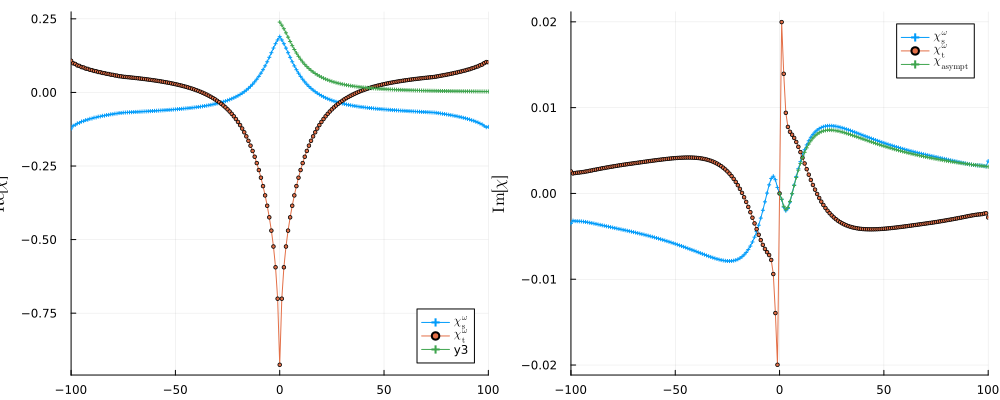

In [82]:
display(L"\chi^{\nu_0\omega_0}_{\mathrm{ph},0} = \chi^{\nu_0\omega_1}_{\mathrm{pp},0}: ")
println(χ0_full[0,0] ≈ χ0_pp_full[1, 0])
χs_t = reshape_lin_to_rank3(χs,nBose,nFermi);
χs_t[isnan.(χs_t)] .= 0.0
χs_ω = dropdims(sum(χs_t,dims=(2,3)), dims=(2,3)) ./ β^2;
χt_t = reshape_lin_to_rank3(χt,nBose,nFermi);
χt_t[isnan.(χt_t)] .= 0.0
χt_ω = dropdims(sum(χt_t,dims=(2,3)), dims=(2,3)) ./ β^2;
p1 = Plots.plot(-nBose:nBose, real(χs_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{s}}", xlims=(-100,100), ylabel=L"\mathrm{Re}[\chi]")
Plots.plot!(-nBose:nBose, real(χt_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{t}}")
Plots.plot!(0:length(χ_pp_asympt)-1, 2 .* real(χ_pp_asympt/β^2), markershape=:auto, markersize=2)
p2 = Plots.plot(-nBose:nBose, imag(χs_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{s}}", xlims=(-100,100), ylabel=L"\mathrm{Im}[\chi]")
Plots.plot!(-nBose:nBose, imag(χt_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{t}}")
Plots.plot!(0:length(χ_pp_asympt)-1, 2 .* imag(χ_pp_asympt/β^2), markershape=:auto, markersize=2, label=L"\chi_{\mathrm{asympt}}")
Plots.plot(p1,p2, size=(1000,400))

In [47]:
# ========== Local BSE ==========
#   This is implemented in GFTools.jl in VertexPostprocessing.jl/src
Fm = VertexPostprocessing.F_from_χ(:m, χm, χ0_full, β, shift, nBose, nFermi)
Fd = VertexPostprocessing.F_from_χ(:d, χd, χ0_full, β, shift, nBose, nFermi)
Γm = computeΓ_ph(freqList, χm, χ0_full, nBose, nFermi)
Γd = computeΓ_ph(freqList, χd, χ0_full, nBose, nFermi)
χm_loc = reshape_lin_to_rank3(χm,nBose,nFermi)
χd_loc = reshape_lin_to_rank3(χd,nBose,nFermi)
println("Done with ph channel!")

Done with ph channel!


In [48]:
χuu, χup = m_d_TO_uu_ud(χm, χd)
Fuu = VertexPostprocessing.F_from_χ(:m, χuu, χ0_full, β, shift, nBose, nFermi)
Fud = VertexPostprocessing.F_from_χ(:d, χup, χ0_full, β, shift, nBose, nFermi);

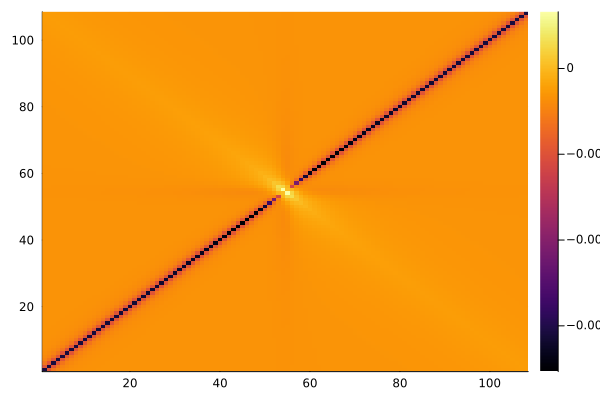

In [49]:
Plots.heatmap(real(Γm[151,97:end-96,97:end-96]))

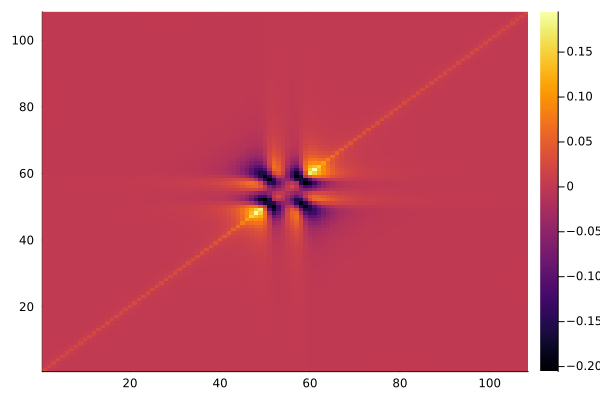

In [50]:
Plots.heatmap(real(Γd[151,97:end-96,97:end-96] .- U / β^2 ))

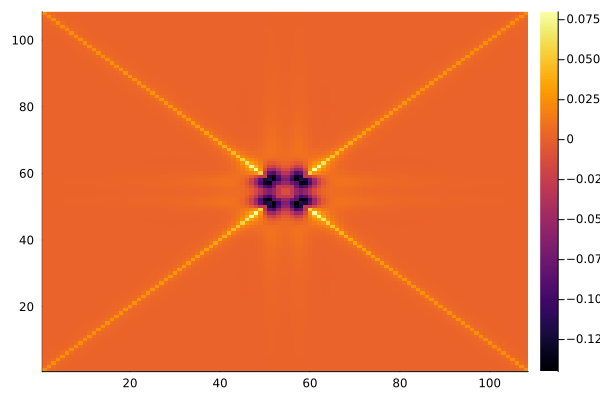

In [51]:
Plots.heatmap(real(Γs[151,97:end-96,97:end-96]))

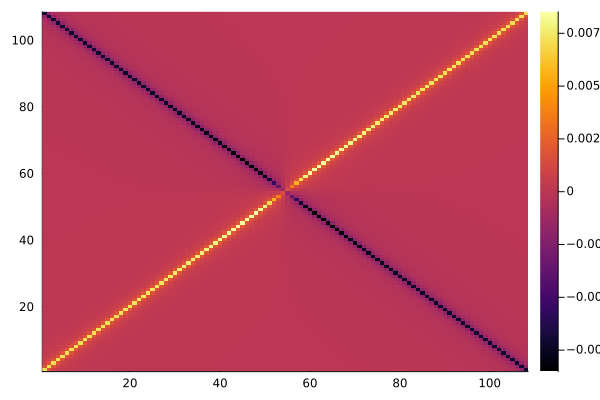

In [52]:
Plots.heatmap(real(Γt[151,97:end-96,97:end-96]))

In [53]:
Γs, Γt       = computeΓ_pp(freqList, χs, χt, χ0_pp_full, nBose, nFermi);

In [54]:
freqList_t = reshape_lin_to_rank3(freqList,nBose,nFermi)
freqList_t[149,:,:];
χs_t = reshape_lin_to_rank3(χs,nBose,nFermi);

In [55]:
Fs = VertexPostprocessing.F_from_χ(:s, reshape_lin_to_rank3(χs,nBose,nFermi), χ0_pp_full, β, shift, nBose, nFermi);
Ft = VertexPostprocessing.F_from_χ(:t, reshape_lin_to_rank3(χt,nBose,nFermi), χ0_pp_full, β, shift, nBose, nFermi);

In [56]:
β

50.0

## Construction of Fpp

The notebook `Test_F_ladder_pp.ipynb` has details and tests for the functions that are used to construct Φs and Φt.


## Asymptotic Behavior

The asymptotic behavior is given here, the variables for diagonal and background are defined in the next cell.

### $\Gamma$ 

$\Gamma^{\nu\nu'\omega}_d \sim \phantom{-}U + \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2 }\chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp,\uparrow\downarrow} $

$\Gamma^{\nu\nu'\omega}_m \sim -U + \frac{U^2}{2} \chi^{\nu'-\nu}_d - \frac{U^2}{2} \chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp,\uparrow\downarrow} $

$\Gamma^{\nu\nu'\omega}_s \sim 2U - \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{3U^2}{2} \chi^{\omega-\nu-\nu'}_{m} $

$\Gamma^{\nu\nu'\omega}_t \sim \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_{m} $

### $F$

$F^{\nu\nu'\omega}_d \sim \phantom{-}U + \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2 }\chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp} + U \lambda^{\nu\omega}_d + U \lambda^{\nu'\omega}_d + U^2 \chi^{\omega}_d$

$F^{\nu\nu'\omega}_m \sim -U + \frac{U^2}{2} \chi^{\nu'-\nu}_d - \frac{U^2}{2} \chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp}  + U \lambda^{\nu\omega}_m + U \lambda^{\nu'\omega}_m + U^2 \chi^{\omega}_m$

$F^{\nu\nu'\omega}_s \sim 2U - \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{3U^2}{2} \chi^{\omega-\nu-\nu'}_{m} + 2U \lambda^{\nu\omega}_{pp,\uparrow\downarrow} + 2U \lambda^{\nu'\omega}_{pp,\uparrow\downarrow} + 2 U^2 \chi^{\omega}_{pp,\uparrow\downarrow}$

$F^{\nu\nu'\omega}_t \sim  \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_{m}$


In [57]:
# Parameters 
ωn = 0
ωi0 = nBose+ωn+1;
bg_ind = floor(Int, size(Fd,2)*(1.4/4))
bg_offset = 5
nan_ind = trunc(Int,nBose/2+8);

In [58]:
# Print function
function format_out(val, lim; digits=5)
    lim_s = lpad(rpad(round(real(lim),digits=digits), 6, "0"),10, " ")
    val_s = lpad(rpad(round(real(val),digits=digits), 6, "0"),10, " ")
    sim = (isapprox(val, lim, rtol=0.05) || (abs(val) < 0.1 && abs(lim) < 0.1 )) ? "\e[1m\e[38;2;0;150;50;249m✓\x1b[0m" :  "\e[1m\e[38;2;250;0;0;249m↯\x1b[0m"
    return "$val_s ≟ $lim_s  " * sim
end


# Definitions

Γd_lim_diag  =  U + 0.5 * U^2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 
Γm_lim_diag  = -U + 0.5 * U^2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 
Γs_lim_diag  = 2U - 0.5 * U^2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2
Γt_lim_diag  =  0 + 0.5 * U^2 * χ_d_asympt[1]/β^2 + 0.5 * U^2 * χ_m_asympt[1]/β^2;

Γd_lim_adiag =  U - 1.0 * U^2 * χ_pp_asympt[1]/β^2 
Γm_lim_adiag = -U + 1.0 * U^2 * χ_pp_asympt[1]/β^2  
Γs_lim_adiag = 2U - 0.5 * U^2 * χ_d_asympt[1] /β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2
Γt_lim_adiag =  0 - 0.5 * U^2 * χ_d_asympt[1] /β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2;

Γd_lim_bg =  U
Γm_lim_bg = -U
Γs_lim_bg = 2U
Γt_lim_bg = 0.0;

Fd_lim_diag =  U + U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 1 * U^2 * χ_d_asympt[1]/β^2
Fm_lim_diag = -U + U^2/2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 - 1 * U^2 * χ_m_asympt[1]/β^2
Fs_lim_diag = 2U - U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_diag =      U^2/2 * χ_d_asympt[1]/β^2 + 0.5 * U^2 * χ_m_asympt[1]/β^2 ;

Fd_lim_adiag =  U - U^2 * χ_pp_asympt[1]/β^2 - 1 * U^2 * χ_d_asympt[1]/β^2
Fm_lim_adiag = -U + U^2 * χ_pp_asympt[1]/β^2 - 1 * U^2 * χ_m_asympt[1]/β^2
Fs_lim_adiag = 2U - U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_adiag =    - U^2/2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 ;

Fd_lim_bg =  U - 1 * U^2 * χ_d_asympt[1]/β^2 
Fm_lim_bg = -U - 1 * U^2 * χ_m_asympt[1]/β^2 
Fs_lim_bg = 2U - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_bg = 0.0;


# - compensates global -1 factor in script

println("                   numerical ≟ exact")
println("   ================ Γ ==================   ")
println("Diagonal Γd   :   $(format_out(Γd[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γd_lim_diag))")
println("Diagonal Γm   :   $(format_out(Γm[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γm_lim_diag))")
println("Diagonal Γs   :   $(format_out(Γs[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γs_lim_diag))")
println("Diagonal Γt   :   $(format_out(Γt[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γt_lim_diag))")

println("Anti-Diagonal Γd   :   $(format_out(Γd[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γd_lim_adiag))")
println("Anti-Diagonal Γm   :   $(format_out(Γm[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γm_lim_adiag))")
println("Anti-Diagonal Γs   :   $(format_out(Γs[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γs_lim_adiag))")
println("Anti-Diagonal Γt   :   $(format_out(Γt[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γt_lim_adiag))")

println("Background Γd :   $(format_out(Γd[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γd_lim_bg))")
println("Background Γm :   $(format_out(Γm[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γm_lim_bg))")
println("Background Γs :   $(format_out(Γs[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γs_lim_bg))")
println("Background Γt :   $(format_out(Γt[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γt_lim_bg))")

println("   ================ F ==================   ")
println("Diagonal Fd   :   $(format_out(Fd[ωi0,nan_ind+1,nan_ind+1], Fd_lim_diag))")
println("Diagonal Fm   :   $(format_out(Fm[ωi0,nan_ind+1,nan_ind+1], Fm_lim_diag))")
println("Diagonal Fs   :   $(format_out(Fs[ωi0,nan_ind+1,nan_ind+1], Fs_lim_diag))")
println("Diagonal Ft   :   $(format_out(Ft[ωi0,nan_ind+1,nan_ind+1], Ft_lim_diag))")

println("Anti-Diagonal Fd   :   $(format_out(Fd[ωi0,nan_ind+1,end-nan_ind], Fd_lim_adiag))")
println("Anti-Diagonal Fm   :   $(format_out(Fm[ωi0,nan_ind+1,end-nan_ind], Fm_lim_adiag))")
println("Anti-Diagonal Fs   :   $(format_out(Fs[ωi0,nan_ind+1,end-nan_ind], Fs_lim_adiag))")
println("Anti-Diagonal Ft   :   $(format_out(Ft[ωi0,nan_ind+1,end-nan_ind], Ft_lim_adiag))")

println("Background Fd :   $(format_out(Fd[ωi0,nan_ind+1,bg_ind+bg_offset], Fd_lim_bg))")
println("Background Fm :   $(format_out(Fm[ωi0,nan_ind+1,bg_ind+bg_offset], Fm_lim_bg))")
println("Background Fs :   $(format_out(Fs[ωi0,nan_ind+1,bg_ind+bg_offset], Fs_lim_bg))")
println("Background Ft :   $(format_out(Ft[ωi0,nan_ind+1,bg_ind+bg_offset], Ft_lim_bg))")

                   numerical ≟ exact
   ================ Γ ==================   
Diagonal Γd   :     55.67955 ≟   53.85839  ✓
Diagonal Γm   :    -19.23722 ≟  -18.96547  ✓
Diagonal Γs   :     56.94244 ≟    55.3774  ✓
Diagonal Γt   :     17.67482 ≟   17.44646  ✓
Anti-Diagonal Γd   :      1.39232 ≟    1.52213  ↯
Anti-Diagonal Γm   :     -1.56659 ≟   -1.52213  ✓
Anti-Diagonal Γs   :     56.94244 ≟    55.3774  ✓
Anti-Diagonal Γt   :    -17.67482 ≟  -17.44646  ✓
Background Γd :      2.10983 ≟     2.0000  ↯
Background Γm :     -2.06718 ≟     -2.000  ✓
Background Γs :       3.8302 ≟     4.0000  ✓
Background Γt :      0.07206 ≟     0.0000  ✓
   ================ F ==================   
Diagonal Fd   :     54.25265 ≟    53.3774  ✓
Diagonal Fm   :    -54.25262 ≟   -53.3774  ✓
Diagonal Fs   :     55.18262 ≟   54.42166  ✓
Diagonal Ft   :     17.77814 ≟   17.44646  ✓
Anti-Diagonal Fd   :       0.9241 ≟    1.04114  ↯
Anti-Diagonal Fm   :    -36.48038 ≟  -35.93406  ✓
Anti-Diagonal Fs   :     55.18262 ≟

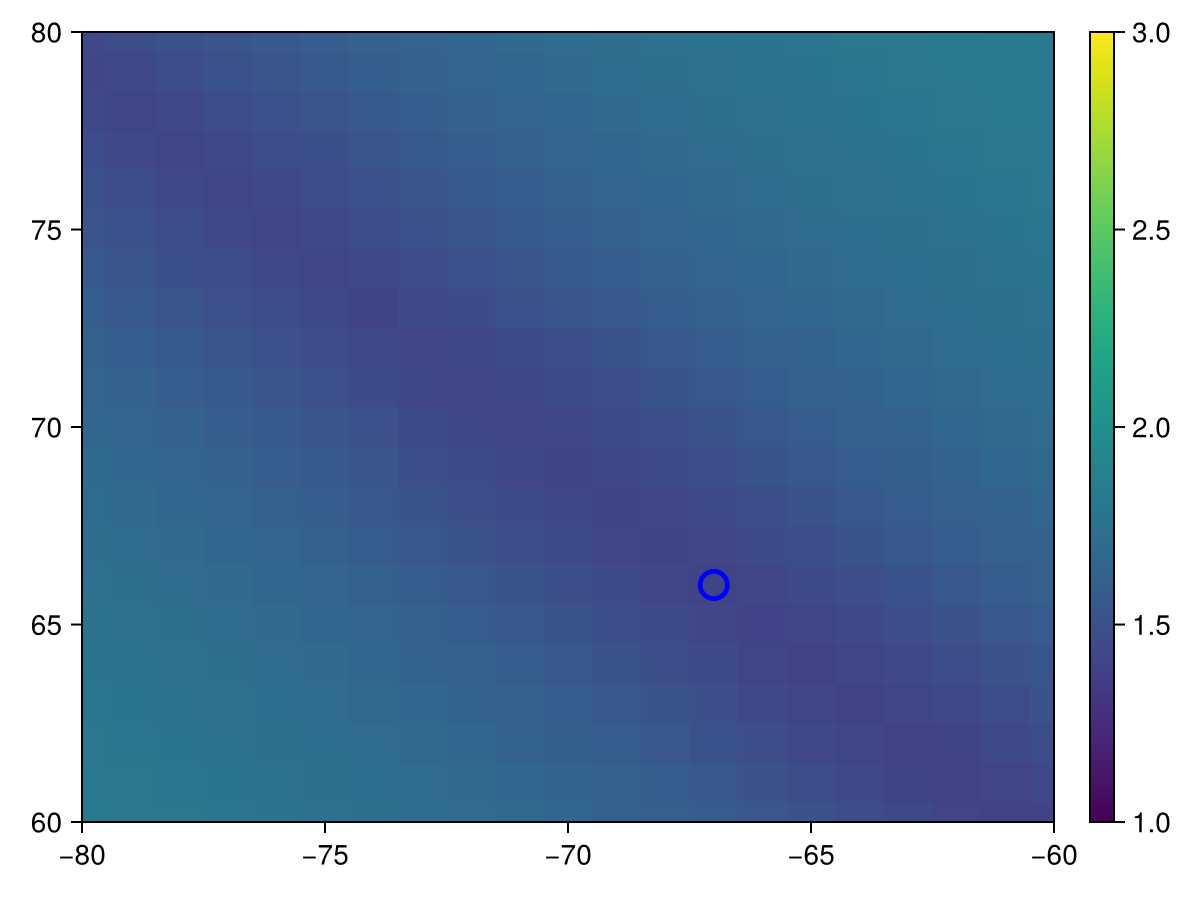

In [59]:
f = Figure()
ax = Axis(f[1, 1],limits=(-80,-60,60,80)) #(nan_ind-nFermi-1,120-nFermi-1,nan_ind-nFermi-1,120-nFermi-1)  #, limits=(-75,-60,60,75)
p_big = decompose(Point2f, Circle(Point2f(0), 1))
p_small = decompose(Point2f, Circle(Point2f(0), 0.7))
marker = Polygon(p_big, [p_small])
hm = CairoMakie.heatmap!(ax, -nFermi:nFermi-1, -nFermi:nFermi-1, real(Γd[151,:,:]) .* β^2, colorrange = (1,3))
CairoMakie.scatter!(ax, [nan_ind+1-nFermi-1],[nan_ind+1-nFermi-1], marker=marker, markersize=8, strokewidth=0, color=:red, label="Diagonal")
CairoMakie.scatter!(ax, [nan_ind+1-nFermi-1],[size(Γd,2)-nan_ind-nFermi-1], marker=marker, markersize=8, strokewidth=0, color=:blue, label="Anti-Diag")
CairoMakie.scatter!(ax, [nan_ind+1-nFermi-1],[bg_ind+bg_offset-nFermi-1], marker=marker, markersize=8, strokewidth=0, color=:green, label="Background")
CairoMakie.Colorbar(f[:, end+1], hm) 
f

## Debug Plots

Below are some plots for the real and imaginary parts of F and Γ as a function of the fermionic frequencies. 
Adjust `ωn` to the Matsubaraindex (this is not the array index but the real one).

In [60]:
ωn = 0

f = Figure()
ax1 = Axis(f[1, 1], limits=(nan_ind,120,nan_ind,120))
ax2 = Axis(f[1, 2], limits=(nan_ind,120,nan_ind,120))
ax3 = Axis(f[2, 1], limits=(nan_ind,120,nan_ind,120))
ax4 = Axis(f[2, 2], limits=(nan_ind,120,nan_ind,120))
heatmap!(ax1, real(Γm[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Re \Gamma^{\omega_{%$ωn},\nu\nu'}_m")
heatmap!(ax2,imag(Γm[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Im \Gamma^{\omega_{%$ωn},\nu\nu'}_m")
heatmap!(ax3,real(Γd[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Re \Gamma^{\omega_{%$ωn},\nu\nu'}_d")
heatmap!(ax4,imag(Γd[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Im \Gamma^{\omega_{%$ωn},\nu\nu'}_d")
Colorbar(f[:, end+1], hm) 
f

LoadError: UndefVarError: `heatmap!` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name may be made accessible by importing MakieCore in the current active module Main
Hint: a global variable of this name also exists in Makie.
Hint: a global variable of this name also exists in CairoMakie.
Hint: a global variable of this name also exists in Plots.

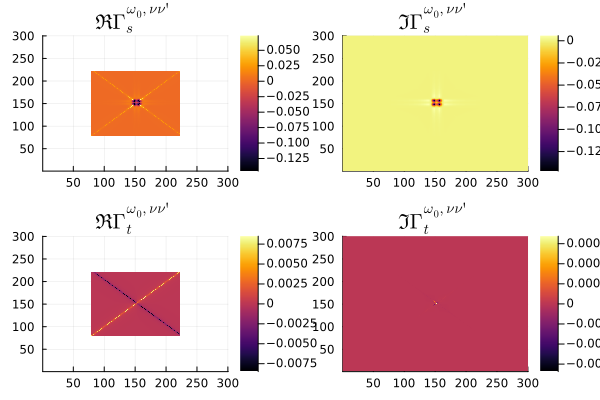

In [61]:
p1 = Plots.heatmap(real(Γs[nBose + ωn + 3, :, :]), title=L"\Re \Gamma^{\omega_{%$ωn},\nu\nu'}_s")
p2 = Plots.heatmap(imag(Γs[nBose + ωn + 3, :, :]), title=L"\Im \Gamma^{\omega_{%$ωn},\nu\nu'}_s")
p3 = Plots.heatmap(real(Γt[nBose + ωn + 3, :, :]), title=L"\Re \Gamma^{\omega_{%$ωn},\nu\nu'}_t")
p4 = Plots.heatmap(imag(Γt[nBose + ωn + 3, :, :]), title=L"\Im \Gamma^{\omega_{%$ωn},\nu\nu'}_t")
Plots.plot(p1,p2,p3,p4)

In [62]:
p1 = heatmap(real(Fm[nBose + ωn + 1, :, :]), title=L"\Re F^{\omega_%$ωn,\nu\nu'}_m")
p2 = heatmap(imag(Fm[nBose + ωn + 1, :, :]), title=L"\Im F^{\omega_%$ωn,\nu\nu'}_m")
p3 = heatmap(real(Fd[nBose + ωn + 1, :, :]), title=L"\Re F^{\omega_%$ωn,\nu\nu'}_d")
p4 = heatmap(imag(Fd[nBose + ωn + 1, :, :]), title=L"\Im F^{\omega_%$ωn,\nu\nu'}_d")
plot(p1,p2,p3,p4)

LoadError: UndefVarError: `heatmap` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name may be made accessible by importing MakieCore in the current active module Main
Hint: a global variable of this name also exists in Makie.
Hint: a global variable of this name also exists in CairoMakie.
Hint: a global variable of this name also exists in Plots.

## Linearized Eliashberg Equations

### Equations

Equations should something like this:

$ \gamma^{\nu\omega}_{m/d,q} = \beta (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}\sum \chi^{\star,\nu\nu'\omega}_{m/d,q} \pm 1 $ 


$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1} 
            -  \beta^2 (\chi^{\nu\omega}_0)^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_0)^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \sum_{\nu_1\nu_2}\chi^{*,\nu\nu_1\omega}_{r,\mathbf{q}} \chi^{*,\nu_2\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} $

<mark>pm 1 missing</mark>

$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = 
            \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}
            -  \beta^2 (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\gamma^{\nu\omega}_r \mp 1) (\gamma^{\nu'\omega}_r \mp 1) $
        
$ F^{\nu\nu'\omega}_{r,\mathbf{q}} =
        \beta^2 \left( \chi^{\nu\nu'\omega}_{0,\mathbf{q}} \right)^{-1} 
        +  \beta^2 \left( \chi^{\nu\omega}_{0,\mathbf{q}} \right)^{-1}  \chi^{\nu\nu'\omega}_{r,\mathbf{q}} \left( \chi^{\nu'\omega}_{0,\mathbf{q}} \right)^{-1} $
        

$  F^{\nu\nu'\omega}_{\mathrm{ladder,ph,\uparrow\downarrow}, kk'q} =  \frac{1}{2} \left(
            F^{\lambda,\nu\nu'\omega}_{\mathrm{m},q}
            - F^{\lambda,\nu\nu'\omega}_{\mathrm{d},q} 
        \right) 
        + F^{\lambda,\nu(\omega+\nu)(\nu' - \nu)}_{\mathrm{m},k' - k}
        - F^{\nu\nu'\omega}_{\mathrm{loc},\uparrow\downarrow} $

$ \Phi_{\mathrm{pp},\uparrow\downarrow} = \frac{1}{2} (\Phi_\mathrm{s}  +\Phi_\mathrm{t})$

$  \Gamma^{\nu\nu'\omega}_{\mathrm{s},kk'q} := \Gamma^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\downarrow,kk'q} 
    = 
        F^{\nu'(-\nu)(\nu-\nu')}_{\mathrm{ladder},k'(-k)(k-k')} 
        - \Phi^{\nu\nu'\omega}_{\mathrm{loc},\mathrm{pp},\uparrow\downarrow,kk'q=0}  $
        
$\Gamma^{\nu\nu'\omega}_{s,kk'q} = \frac{1}{2} \left(
            F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{m},k-k'}
            - F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{d},k-k'} 
        \right) 
        + F^{\lambda,\nu'\nu(-\nu' - \nu)}_{\mathrm{m},k' - k}
        - F^{\nu(-\nu)(\nu-\nu')}_{\mathrm{loc},\uparrow\downarrow} - \Phi^{\nu\nu'\omega}_{\mathrm{pp},\mathrm{loc},\uparrow\downarrow}$
        
$\Gamma^{\nu\nu'\omega}_{s,kk'q} = 
             F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{d},k-k'}
            -\frac{3}{2} 
            F^{\lambda,\nu\nu'(-\nu-\nu')}_{\mathrm{m},k-k'}
        - F^{\nu(-\nu)(\nu-\nu')}_{\mathrm{loc},\uparrow\downarrow} - \Phi^{\nu\nu'\omega}_{\mathrm{pp},\mathrm{loc},\uparrow\downarrow}$
        
$ \lambda \Delta^{\nu}_{k} = -\frac{1}{\beta N_k} \sum_{\nu' k'} \Gamma^{\nu\nu'\omega=0}_{kk'q=0} \chi^{\nu\nu'\omega_0}_{0,\mathrm{s},k'} \Delta^{\nu'}_{k'}$

`Test_F_ladder_pp.ipynb` has more details.


### Implementation

The file `src/LinearizedEliashberg.jl` in `LadderDGA.jl` implements this.

<mark>Check equations and implementation in `calc_Γs_ud` and `calc_λmax_linEliashberg`.</mark>

Remember that we need the particle-particle bubble here, which is computed with `build_GG`.

There are two versions of the function that calculates the leading eigenvalue: `calc_λmax_linEliashberg` and `calc_λmax_linEliashberg_MatrixFree`. 
One is matrix-free (i.e. Γs is not explicitly stored in memory, this is surprisingly fast) and one that uses subsampling in the q-space (remember to provide max_Nk, otherwise no subsampling is performed).

In [4]:
cfg_file = joinpath(dataDir, "lDGAConfig.toml")

wp, mP, sP, env, kGridsStr = readConfig(cfg_file);
lDGAhelper = setup_LDGA(kGridsStr[1], mP, sP, env, silent=false);
bubble     = calc_bubble(:DMFT, lDGAhelper);
χm_nl, γm_nl = calc_χγ(:m, lDGAhelper, bubble; ω_symmetric=false);
χd_nl, γd_nl = calc_χγ(:d, lDGAhelper, bubble; ω_symmetric=false);
λ₀ = calc_λ0(bubble, lDGAhelper);

[ Info: Reading Inputs...
┌ Warning: Setting dbg_full_chi_omega = true can cause the magnetic correction to yield wrong results!!
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\IO.jl:46
[ Info: Setting up calculation for kGrid 2Dsc-0.25-0.05-0.025 of size 10
┌ Warning: The find_usable_range function should not be used carefully the DMFT phase transition. PLEASE FIX THIS!
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\GFFit.jl:45
┌ Warning: The find_usable_range function should not be used carefully the DMFT phase transition. PLEASE FIX THIS!
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\GFFit.jl:45


DBG: NOT using diagonal terms in λ₀


┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_m([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203

DBG: NOT using diagonal terms in λ₀


In [5]:
χm_nl2, γm_nl2 = calc_χγ(:m, lDGAhelper, bubble; ω_symmetric=true);
χd_nl2, γd_nl2 = calc_χγ(:d, lDGAhelper, bubble; ω_symmetric=true);

[ Info: m channel: |∑χ(q=0,ω≠0)| = 0.032257314716 ≟ 0
┌ Warning: The find_usable_range function should not be used carefully the DMFT phase transition. PLEASE FIX THIS!
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\GFFit.jl:45
[ Info: d channel: |∑χ(q=0,ω≠0)| = 0.022694204622 ≟ 0
┌ Warning: The find_usable_range function should not be used carefully the DMFT phase transition. PLEASE FIX THIS!
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\GFFit.jl:45


In [6]:
maximum(abs.(γm_nl2 .- γm_nl))

2.390410112598977e-5

In [15]:
γm_nl2 = zeros(size(γm_nl.data));
χm_nl2 = zeros(size(χm_nl.data));

In [ ]:
ωm_range = ω_symmetric ? (0:(sP.n_iω)) : ((-sP.n_iω):(sP.n_iω))
for qi in 1:size(γ.data, 1)
for ωm in ωm_range
if ω_symmetric && ωm > 0
                ωi_mirror =  sP.n_iω + 1 - ωm
                χ[qi, ωi_mirror] = χm_nl[qi, ωi]
                γm_nl2[qi, :, ωi_mirror] = conj(reverse(γm_nl2[qi, :, ωi_mirror]))
            end
    end
end

In [30]:
maximum(abs.(γd_nl[:,:,1] .- conj.(reverse(γd_nl[:,:,end], dims=2))))

2.2250583330149848e-5

In [16]:
res_m     = λm_correction(χm_nl, γm_nl, χd_nl, γd_nl, λ₀, lDGAhelper); print(res_m)
res_dm     = λdm_correction(χm_nl, γm_nl, χd_nl, γd_nl, λ₀, lDGAhelper); print(res_dm)

╭──── λ-correction (type: LadderDGA.LambdaCorrection.mCorrection),... ─────────╮
│  λm = 0.13995786, λd = 0.00000000, μ = 0.81245062                            │
│  n      =  0.97955815,  n DMFT  =  0.97955815,  Δ = 0.0000%                  │
│  PP_1   =  0.24989553,  PP_2    =  0.24989553,  Δ = 0.0000%                  │
│  Epot_1 =  0.09347674,  Epot_2  =  0.12996545,  Δ = 16.3303%                 │
│  Ekin_1 =  -0.24180707,  Ekin_2  = -0.23984412,  Δ = 0.4075%                 │
│  χ_m    =  0.42479635,  χ_m_loc = 0.42306663,  Δ = 0.2040%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭──── λ-correction (type: LadderDGA.LambdaCorrection.dmCorrection),... ────────╮
│  λm = 0.13930946, λd = 10.70145591, μ = 0.80248254                           │
│  n      =  0.97955815,  n DMFT  =  0.97955815,  Δ = 0.0000%                  │
│  PP_1   =  0.24989553,  PP

In [6]:
Φs, Φt = jldopen(joinpath(env.inputDir, "DMFT2_out.jld2"), "r") do f
    f["Φpp_s"], f["Φpp_t"]
end
Φs = permutedims(Φs, [2, 3, 1])
Φt = permutedims(Φt, [2, 3, 1])
Φ_ud = 0.5 .* (Φs .+ Φt)

lDGAhelper_Ur = deepcopy(lDGAhelper)
lDGAhelper_Ur.Γ_m[:, :, :] = lDGAhelper_Ur.Γ_m[:, :, :] .- (-lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)
lDGAhelper_Ur.Γ_d[:, :, :] = lDGAhelper_Ur.Γ_d[:, :, :] .- ( lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)
χm_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_m, bubble, lDGAhelper_Ur.kG)
χd_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_d, bubble, lDGAhelper_Ur.kG);

In [7]:
χm_nl_λdm = χ_λ(χm_nl, res_dm.λm)
χd_nl_λdm = χ_λ(χd_nl, res_dm.λd);

In [8]:
Fm_λ0 = LadderDGA.F_from_χ_star_gen(bubble, χm_star_gen, χm_nl, γm_nl, -lDGAhelper.mP.U)
Fd_λ0 = LadderDGA.F_from_χ_star_gen(bubble, χd_star_gen, χd_nl, γd_nl,  lDGAhelper.mP.U);
Fm_λdm = LadderDGA.F_from_χ_star_gen(bubble, χm_star_gen, χm_nl_λdm, γm_nl, -lDGAhelper.mP.U)
Fd_λdm = LadderDGA.F_from_χ_star_gen(bubble, χd_star_gen, χd_nl_λdm, γd_nl,  lDGAhelper.mP.U);

In [9]:
build_kGrid_subsample = LadderDGA.build_kGrid_subsample
Dispersions = LadderDGA.Dispersions
grid_type = LadderDGA.grid_type
grid_dimension = LadderDGA.grid_dimension
build_GG = LadderDGA.build_GG
build_q_access = LadderDGA.build_q_access
Freq_to_OneToIndex = LadderDGA.Freq_to_OneToIndex
freq_inbounds = LadderDGA.freq_inbounds;

In [10]:
μ = lDGAhelper.mP.μ
Σ = lDGAhelper.Σ_loc

max_Nk = lDGAhelper.kG.Nk
GF = lDGAhelper.gLoc
cut_to_non_nan = true
max_ν = 20 #cut_to_non_nan ? trunc(Int, lDGAhelper.sP.n_iν / 2 - 3) : lDGAhelper.sP.n_iν
νnGrid = (-max_ν):(max_ν-1) #-1:0 #-
kG, sub_i = build_kGrid_subsample(lDGAhelper.kG, max_Nk)
println("lDΓA k-grid: ", lDGAhelper.kG, "linearized Eliashberg Eq. k-grid: ", kG)

k_vecs = collect(Dispersions.gen_sampling(grid_type(kG), grid_dimension(kG), kG.Ns))

νlen = length(νnGrid)
klen = length(k_vecs)
ωi_pp = lDGAhelper.sP.n_iω + 1

Fm_loc = LadderDGA.F_from_χ(:m, lDGAhelper)
Fd_loc = LadderDGA.F_from_χ(:d, lDGAhelper)
qi_access = build_q_access(kG, k_vecs[:]);

Brute force checking for possible sub-samples. This needs to be rewritten
lDΓA k-grid: Dispersions.cPnn(t=0.25) grid in 2 dimensions with 100 k-points.linearized Eliashberg Eq. k-grid: Dispersions.cPnn(t=0.25) grid in 2 dimensions with 100 k-points.


In [11]:
Fm_ladder = Fm_λdm;
Fd_ladder = Fd_λdm;
h = lDGAhelper;

In [12]:
function getG_naive(kG, Σ, kp, νp, μ, β)
    ϵk = LadderDGA.Dispersions.gen_ϵkGrid(LadderDGA.Dispersions.grid_type(kG), [kp], kG.t, kG.tp, kG.tpp)[1]
    Σν = νp > -1 ? Σ[νp] : conj(Σ[-νp-1])
    Gk = 1/(1im * (2*νp+1)*π/β + μ - ϵk - Σν)
    return Gk
end

function χ₀_naive(kG, Σ, kp, νp, μ, β)
    Gk = getG_naive(kG, Σ, kp, νp, μ, β)
    G_minusk = getG_naive(kG, Σ, -1 .* kp, -νp-1, μ, β)
    return Gk*G_minusk
end


function build_χ₀pp_vec(Σ, k_vecs, νnGrid, μ, β)
    χ₀_vec = Array{ComplexF64,1}(undef, length(k_vecs) * length(νnGrid))

    for (νpi, νpn) in enumerate(νnGrid)
        for (kpi, kp_vec) in enumerate(k_vecs)
            χ₀_vec[kpi+length(k_vecs)*(νpi-1)] = χ₀_naive(kG, Σ, kp_vec, νpn, μ, β)
        end
    end
    return χ₀_vec
end

#χ₀_vec = build_χ₀pp_vec(lDGAhelper.Σ_loc, k_vecs, νnGrid, μ, β);

build_χ₀pp_vec (generic function with 1 method)

In [13]:
Γs_ladder1 = nothing
GC.gc()

In [14]:
Γs_ladder1 = Array{ComplexF64,2}(undef, νlen * klen, νlen * klen)
fill!(Γs_ladder1, NaN + 1im * NaN);
Fph_ladder_updo = permutedims(-1.5 .* Fm_ladder[:, :, sub_i, :].+ 0.5 .* Fd_ladder[:, :, sub_i, :], [3, 1, 2, 4]) .- reshape(0.5 .* Fd_loc .- 0.5 .* Fm_loc, 1, size(Fd_loc)...)

for (νi, νn) in enumerate(νnGrid)
    for (νpi, νpn) in enumerate(νnGrid)
        ν_minus_νp = νn - νpn            # 2m = (2n+1) - (2n' + 1) => m = n-n'
        νp_minus_ν = νpn - νn
        minus_ν_minus_νp = -νn - νpn - 1 # 2m = -(2n+1) - (2n' + 1) => m = -n-n'-1
        minus_ν = -νn - 1                # 2n'+1 = -(2n+1) => n' = -n - 1
        minus_νp = -νpn - 1 
        ν_plus_νp = νn + νpn + 1         # 2m = (2n+1) + (2n' + 1) => m = n+n'+1
        νi_pp = νn + lDGAhelper.sP.n_iν + 1
        νpi_pp = νpn + lDGAhelper.sP.n_iν + 1

        ωi_ladder, νi_ladder, νpi_ladder = Freq_to_OneToIndex(ν_minus_νp, νpn, minus_ν, h.sP.shift, h.sP.n_iω, h.sP.n_iν)
        if freq_inbounds(ωi_ladder, νi_ladder, νpi_ladder, h.sP)
            for (kpi, kp_vec) in enumerate(k_vecs)
                for (ki, k_vec) in enumerate(k_vecs)
                    qi = qi_access[ki, kpi]
                    Γs_ladder1[νi+νlen*(ki-1), νpi+νlen*(kpi-1)] =
                        -(Fph_ladder_updo[qi, νi_ladder, νpi_ladder, ωi_ladder] )
                    #.- Φ_ud[νi_pp, νpi_pp, ωi_pp]
                    #* χ₀_naive(kG, Σ, kp_vec, νpn, μ, h.mP.β) / (lDGAhelper.kG.Nk * lDGAhelper.mP.β)
                end
            end
        end
    end
end

In [74]:
mP.\beta

LoadError: UndefVarError: `beta` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing SpecialFunctions in the current active module Main

In [75]:
using LinearAlgebra,Arpack

In [76]:
ti = 0
tpi = 0
ti2 = 0
tpi2 = 3

Γs_ladder1[(ti*νlen+1):((ti+1)*νlen),(tpi*νlen+1):((tpi+1)*νlen)] .- Γs_ladder1[(ti2*νlen+1):((ti2+1)*νlen),(tpi2*νlen+1):((tpi2+1)*νlen)]

40×40 Matrix{ComplexF64}:
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im  …  NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im
 NaN+NaN*im  NaN+NaN*im  NaN+NaN*im     NaN+NaN*im  NaN+NaN*im  NaN+NaN*im

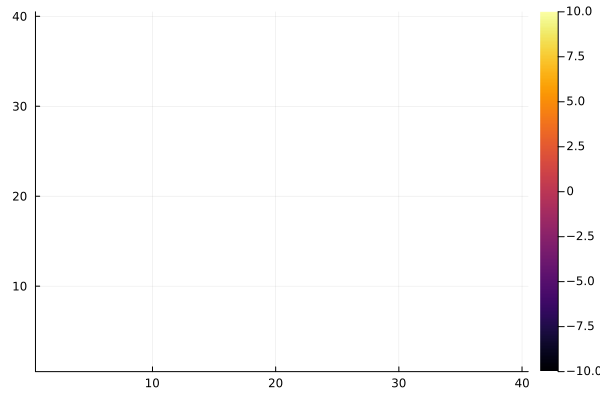

In [77]:
ti = 0
tpi = 5
Plots.heatmap(real(Γs_ladder1[(ti*νlen+1):((ti+1)*νlen),(tpi*νlen+1):((tpi+1)*νlen)] ),clims=(-10,10))

In [78]:
λ1L, _, _, _, _, _ = eigs(Γs_ladder1; nev = 2, which = :LR, tol = 1e-18)

(ComplexF64[NaN + NaN*im, NaN + NaN*im], ComplexF64[NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im; … ; NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im], 2, 1, 20, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])

In [79]:
λ1S, _, _, _, _, _ = eigs(Γs_ladder1; nev = 2, which = :SR, tol = 1e-18)

(ComplexF64[NaN + NaN*im, NaN + NaN*im], ComplexF64[NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im; … ; NaN + NaN*im NaN + NaN*im; NaN + NaN*im NaN + NaN*im], 2, 1, 20, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])

In [80]:
Γs1 = calc_Γs_ud_nb(Fm_λdm, Fd_λdm, Φ_ud, lDGAhelper, lDGAhelper.gLoc; max_Nk = 4)
λ1L, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :LR, tol = 1e-18)
λ1S, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :SR, tol = 1e-18)

LoadError: UndefVarError: `calc_Γs_ud_nb` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [81]:
println("EV: Larges $λ1L smalles $λ1S")

EV: Larges ComplexF64[NaN + NaN*im, NaN + NaN*im] smalles ComplexF64[NaN + NaN*im, NaN + NaN*im]


In [33]:
λ1L, λ1S = calc_λmax_linEliashberg(bubble, χm_nl, χd_nl, γm_nl, γd_nl, lDGAhelper, env; GF = lDGAhelper.gLoc, max_Nk = 4)

LoadError: KeyError: key "Φpp_s" not found

In [34]:
    Γs1 = calc_Γs_ud(Fm, Fd, Phi_ud, h, GF; max_Nk = max_Nk)
    λ1L, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :LR, tol = 1e-18)
    λ1S, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :SR, tol = 1e-18)
    return λ1L, λ1S

LoadError: UndefVarError: `Phi_ud` not defined in `Main`
Suggestion: check for spelling errors or missing imports.